# Hyperparameter Scheduling with Callbacks
---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hyperparameter-Scheduling-with-Callbacks" data-toc-modified-id="Hyperparameter-Scheduling-with-Callbacks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hyperparameter Scheduling with Callbacks</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Initialize" data-toc-modified-id="Initialize-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Initialize</a></span></li></ul></li><li><span><a href="#Hyperparameter-Scheduler" data-toc-modified-id="Hyperparameter-Scheduler-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hyperparameter Scheduler</a></span><ul class="toc-item"><li><span><a href="#Recorder-Callback" data-toc-modified-id="Recorder-Callback-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Recorder Callback</a></span></li><li><span><a href="#Scheduler-Callback" data-toc-modified-id="Scheduler-Callback-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Scheduler Callback</a></span></li></ul></li><li><span><a href="#Cyclical-Learning-Rates" data-toc-modified-id="Cyclical-Learning-Rates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cyclical Learning Rates</a></span><ul class="toc-item"><li><span><a href="#Scheduling-Functions" data-toc-modified-id="Scheduling-Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Scheduling Functions</a></span></li><li><span><a href="#Mixed-Schedules" data-toc-modified-id="Mixed-Schedules-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Mixed Schedules</a></span></li><li><span><a href="#One-Cycle-Learning-Rate-Policy" data-toc-modified-id="One-Cycle-Learning-Rate-Policy-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>One Cycle Learning Rate Policy</a></span></li><li><span><a href="#Stochastic-Gradient-with-Restarts" data-toc-modified-id="Stochastic-Gradient-with-Restarts-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Stochastic Gradient with Restarts</a></span></li></ul></li></ul></div>

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import utils
from utils import Callback

import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from functools import partial

## Initialize

In [3]:
bs = 500
n_classes = 10
nh = 100
lr = 0.3

In [4]:
x_train, y_train, x_test, y_test = utils.get_data()
train_dl, test_dl = utils.get_dataloaders(x_train, y_train, x_test, y_test, batch_size=bs)

In [5]:
data = utils.Databunch(train_dl, test_dl, n_classes)

In [6]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

In [7]:
opt = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy

In [8]:
learner = utils.Learner(model, data, opt, loss_func)

In [9]:
controller = utils.Controller([utils.StatsReporter([utils.accuracy])])
controller.train(learner, epochs=3)

EPOCH#0 	Train loss: 0.470 	 metrics: [0.85766] 	Valid loss: 0.219 	 metrics: [0.9367] 	
EPOCH#1 	Train loss: 0.194 	 metrics: [0.94394] 	Valid loss: 0.153 	 metrics: [0.9582] 	
EPOCH#2 	Train loss: 0.146 	 metrics: [0.9579] 	Valid loss: 0.133 	 metrics: [0.9618] 	


In [10]:
utils.accuracy(learner.model(data.train_ds.x), data.train_ds.y)

tensor(0.9625)

# Hyperparameter Scheduler
---

## Recorder Callback

In [11]:
class Recorder(Callback):
    '''A callback to record the learning rate and loss after each training batch'''
    
    def before_train(self):
        self.lrs, self.losses = [], []
    
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lrs(self):
        plt.plot(self.lrs)
    
    def plot_losses(self):
        plt.plot(self.losses)

**Initialize**

In [12]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

opt = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy

learner = utils.Learner(model, data, opt, loss_func)

**Train with Callbacks**

In [13]:
cb_list = [utils.StatsReporter([utils.accuracy]), Recorder()]

In [14]:
controller = utils.Controller(cb_list)
controller.train(learner, epochs=3)

EPOCH#0 	Train loss: 0.487 	 metrics: [0.85192] 	Valid loss: 0.203 	 metrics: [0.9417] 	
EPOCH#1 	Train loss: 0.193 	 metrics: [0.9431] 	Valid loss: 0.151 	 metrics: [0.9607] 	
EPOCH#2 	Train loss: 0.145 	 metrics: [0.95694] 	Valid loss: 0.126 	 metrics: [0.9665] 	


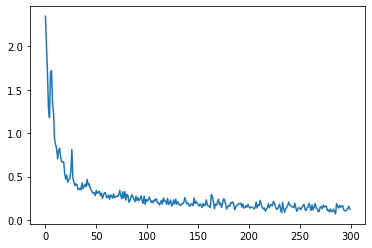

In [15]:
controller.recorder.plot_losses()

## Scheduler Callback

In [16]:
class ParamScheduler(Callback):
    """
    Callback for scheduling any hyperparameter
    registered in the state dict of the optimizer
    """
    
    _order = 1
    
    def __init__(self, param_name, sched_func):
        self.pname, self.sched_func = param_name, sched_func
    
    def set_param(self):
        for group in self.opt.param_groups:
            pos = self.n_epochs/self.epochs
            group[self.pname] = self.sched_func(pos)
    
    def before_batch(self):
        if self.in_train: self.set_param()

In [17]:
def linear_scheduler(start, end):
    def _inner(pos): return start + (end-start)*pos
    return _inner        

**Initialize**

In [18]:
start_lr = 0.01
end_lr = 0.5

In [19]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

opt = torch.optim.SGD(model.parameters(), lr=start_lr)
loss_func = F.cross_entropy

learner = utils.Learner(model, data, opt, loss_func)

**Train with Callbacks**

In [20]:
cb_list = [utils.StatsReporter([utils.accuracy]),
           Recorder(),
           ParamScheduler('lr', linear_scheduler(start_lr, end_lr))]

In [21]:
controller = utils.Controller(cb_list)
controller.train(learner, epochs=3)

EPOCH#0 	Train loss: 0.910 	 metrics: [0.75426] 	Valid loss: 0.342 	 metrics: [0.8977] 	
EPOCH#1 	Train loss: 0.303 	 metrics: [0.90922] 	Valid loss: 0.234 	 metrics: [0.9334] 	
EPOCH#2 	Train loss: 0.225 	 metrics: [0.93238] 	Valid loss: 0.153 	 metrics: [0.9562] 	


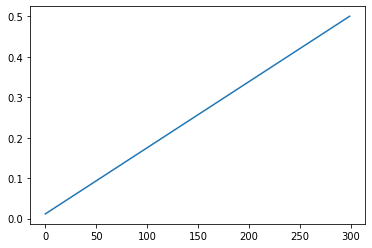

In [22]:
controller.recorder.plot_lrs()

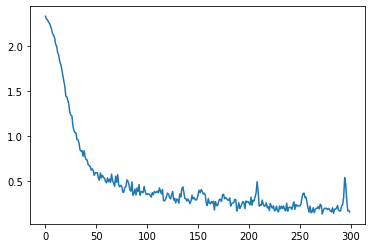

In [23]:
controller.recorder.plot_losses()

# Cyclical Learning Rates
---

## Scheduling Functions

**Let's use a decorator instead of defining the same inner function in every scheduler**

In [24]:
def scheduler(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

In [25]:
@scheduler
def constant(start, end, pos):    return start

@scheduler
def linear(start, end, pos): return start + (end-start)*pos

@scheduler
def exponential(start, end, pos): return start * (end/start)**pos

@scheduler
def cosine(start, end, pos):      return start + (1 + math.cos(math.pi*(1-pos))) * (end-start)/2

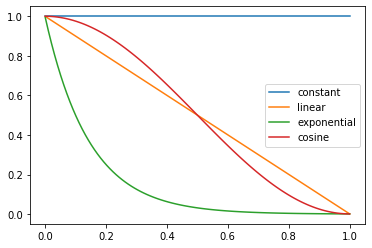

In [26]:
start = 1
end = 1e-3
xs = np.linspace(start, end, 100)
schedulers = [constant, linear, exponential, cosine]
names = ["constant", "linear", "exponential", "cosine"]

for sched, name in zip(schedulers, names):
    f = sched(start, end)
    ys = [f(x) for x in xs]
    plt.plot(xs, ys, label=name)
plt.legend();

## Mixed Schedules

In [27]:
def mixed_schedulers(pcts, schedulers):
    assert sum(pcts) == 1
    pcts = torch.tensor([0] + pcts)
    pcts = torch.cumsum(pcts, dim=0)
    def _inner(pos):
        idx = (pos > pcts).nonzero().max()
        lower_bound, upper_bound = pcts[idx], pcts[idx+1]
        relative_pos = (pos - lower_bound) / (upper_bound-lower_bound)
        return schedulers[idx](relative_pos)
    return _inner

## One Cycle Learning Rate Policy

**Increase the learning rate in the early epochs then gradually reduce it**

In [28]:
one_cycle_sched = mixed_schedulers(pcts = [0.3, 0.7],
                                   schedulers = [cosine(0.1,0.3),
                                                 cosine(0.3,0.001)])

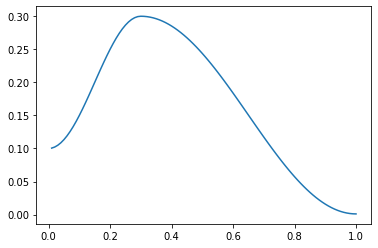

In [35]:
epochs = np.linspace(0.01, 1, 100)
lrs = [one_cycle_sched(x) for x in epochs]
plt.plot(epochs, lrs)

**Initialize**

In [36]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

opt = torch.optim.SGD(model.parameters(), lr=start_lr)
loss_func = F.cross_entropy

learner = utils.Learner(model, data, opt, loss_func)

**Train with Callbacks**

In [37]:
cb_list = [utils.StatsReporter([utils.accuracy]),
           Recorder(),
           ParamScheduler('lr', one_cycle_sched)]

In [38]:
controller = utils.Controller(cb_list)
controller.train(learner, epochs=3)

EPOCH#0 	Train loss: 0.605 	 metrics: [0.83124] 	Valid loss: 0.246 	 metrics: [0.9291] 	
EPOCH#1 	Train loss: 0.220 	 metrics: [0.93666] 	Valid loss: 0.171 	 metrics: [0.9528] 	
EPOCH#2 	Train loss: 0.173 	 metrics: [0.94948] 	Valid loss: 0.161 	 metrics: [0.9552] 	


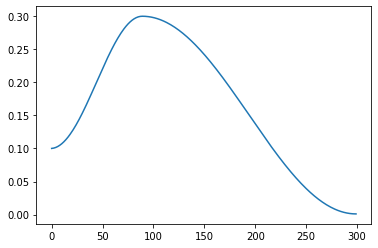

In [39]:
controller.recorder.plot_lrs()

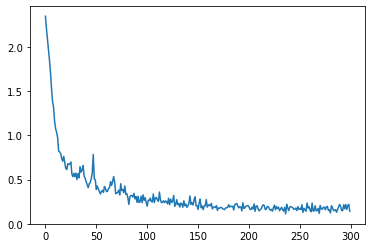

In [40]:
controller.recorder.plot_losses()

## Stochastic Gradient with Restarts

In [41]:
sgdr_sched = mixed_schedulers(pcts = [0.1, 0.2, 0.3, 0.4],
                              schedulers = [cosine(0.01,0.001),
                                            cosine(0.01,0.001),
                                            cosine(0.01,0.001),
                                            cosine(0.01,0.001)])

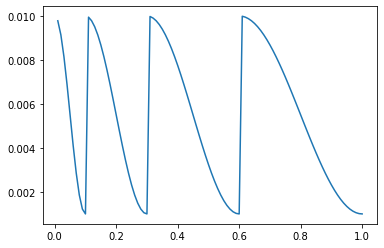

In [42]:
epochs = np.linspace(0.01, 1, 100)
lrs = [sgdr_sched(x) for x in epochs]
plt.plot(epochs, lrs)

**Initialize**

In [43]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

opt = torch.optim.SGD(model.parameters(), lr=start_lr)
loss_func = F.cross_entropy

learner = utils.Learner(model, data, opt, loss_func)

**Train with Callbacks**

In [44]:
cb_list = [utils.StatsReporter([utils.accuracy]),
           Recorder(),
           ParamScheduler('lr', sgdr_sched)]

In [45]:
controller = utils.Controller(cb_list)
controller.train(learner, epochs=10)

EPOCH#0 	Train loss: 1.728 	 metrics: [0.5858] 	Valid loss: 1.428 	 metrics: [0.7285] 	
EPOCH#1 	Train loss: 1.041 	 metrics: [0.78378] 	Valid loss: 0.768 	 metrics: [0.8441] 	
EPOCH#2 	Train loss: 0.755 	 metrics: [0.83082] 	Valid loss: 0.681 	 metrics: [0.8564] 	
EPOCH#3 	Train loss: 0.631 	 metrics: [0.8492] 	Valid loss: 0.516 	 metrics: [0.8775] 	
EPOCH#4 	Train loss: 0.531 	 metrics: [0.8666] 	Valid loss: 0.465 	 metrics: [0.8857] 	
EPOCH#5 	Train loss: 0.502 	 metrics: [0.87188] 	Valid loss: 0.453 	 metrics: [0.8871] 	
EPOCH#6 	Train loss: 0.468 	 metrics: [0.87726] 	Valid loss: 0.404 	 metrics: [0.8947] 	
EPOCH#7 	Train loss: 0.430 	 metrics: [0.88498] 	Valid loss: 0.380 	 metrics: [0.8994] 	
EPOCH#8 	Train loss: 0.411 	 metrics: [0.88836] 	Valid loss: 0.370 	 metrics: [0.9016] 	
EPOCH#9 	Train loss: 0.404 	 metrics: [0.88958] 	Valid loss: 0.367 	 metrics: [0.9024] 	


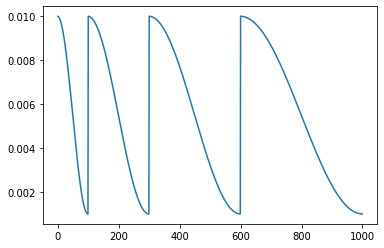

In [46]:
controller.recorder.plot_lrs()

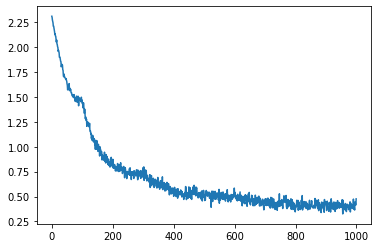

In [47]:
controller.recorder.plot_losses()